In [1]:
"""
Trying Optimus 5' architecture for JTE607 polyA data
"""

import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import pickle
from collections import defaultdict
import os
import OSU
from toolz import interleave

#from tensorflow import keras
#import keras
import tensorflow as tf
np.random.seed(1337)

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Masking
from tensorflow.keras.optimizers import Adam

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 1.5
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def weighted_poly_profile_model_mask(x, y, w, border_mode='same', inp_len=50, nodes=1, layers=1, filter_len=8, nbr_filters=40,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    model = Sequential()
    
    #model.add(Masking(mask_value=-1, input_shape=(inp_len, 4)))

    if layers >= 1:
        model.add(Conv1D(input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
    if layers >= 2:
        model.add(Conv1D(input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(y.shape[1]))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)  # +- 100x scan for lr
    model.compile(loss='mean_squared_error', optimizer=adam, )

    model.fit(x, y, sample_weight=w*len(w), batch_size=64, epochs=nb_epoch, verbose=1)
    return model


def one_hot_encode(sequences, max_seq_len=164, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0],
            'm':[mask_val,mask_val,mask_val,mask_val]}
    
    # Creat empty matrix
    one_hot_seqs = np.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        seq = seq[:max_seq_len].lower()
        # Convert to array
        one_hot_seq = np.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [2]:
# Load JTE607 data from both backbones individually
# Filter based off of DMSO reads per variant
# Adds one to counts if there is a missing PAS from the list generated from DMSO. This is for log ratio.

# L3 loading and counting reads, filter away variants with < 50 reads in DMSO
#L3_shared_5p = "m"*5+"GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAATAATGTACTAGGAGACACTTTCAATAAA"
#L3_shared_3p = "TCGGGTGATTATTTACCCCCCACCCTTGCCGTCTGCGAGAATTCGAT"+"m"*14  #masking right end here to line up hexamer
parsed_L3_cleaved_output_dir = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_L3_DMSO_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_DMSO_polya_pos_dict.pickle"
polyA_L3_0p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_0p5uM_polya_pos_dict.pickle"
polyA_L3_2p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_2p5uM_polya_pos_dict.pickle"
polyA_L3_12p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_12p5uM_polya_pos_dict.pickle"

L3_polyA_pos_pickle_dict = {"L3_DMSO": polyA_L3_DMSO_cleaved_pickle,\
              "L3_0p5uM": polyA_L3_0p5uM_cleaved_pickle,\
             "L3_2p5uM": polyA_L3_2p5uM_cleaved_pickle,\
              "L3_12p5uM": polyA_L3_12p5uM_cleaved_pickle}

L3_PAS_read_counts = defaultdict(int)
polya_pos_dict = pickle.load(open(polyA_L3_DMSO_cleaved_pickle, "rb"))
data_name = "L3_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = sum(curr_polya_pos_count_dict.values())
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        L3_PAS_read_counts[curr_PAS] += curr_total_reads

# SVLst loading and counting reads, filter away variants with < 100 reads in DMSO
#SVLst_shared_5p = "GCGAATTGGAGCTCATGCTTTATTTGTGAAATTTGTGATGCTATTGCTTTATTTGTAACCATTATAAGCTGCAATAAA"
#SVLst_shared_3p = "ATTTTATGTTTCAGGTTCAGGGGGAGGTGTGGGAGGTTTTTTAAAGCAAGTAGAATTCGAT"
parsed_SVLst_cleaved_output_dir = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_SVLst_DMSO_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_polya_pos_dict.pickle"
polyA_SVLst_0p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_0p5uM_polya_pos_dict.pickle"
polyA_SVLst_2p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_2p5uM_polya_pos_dict.pickle"
polyA_SVLst_12p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_polya_pos_dict.pickle"

SVLst_polyA_pos_pickle_dict = {"SVLst_DMSO": polyA_SVLst_DMSO_cleaved_pickle,\
              "SVLst_0p5uM": polyA_SVLst_0p5uM_cleaved_pickle,\
             "SVLst_2p5uM": polyA_SVLst_2p5uM_cleaved_pickle,\
              "SVLst_12p5uM": polyA_SVLst_12p5uM_cleaved_pickle}

SVLst_PAS_read_counts = defaultdict(int)
SVLst_total_reads = 0
polya_pos_dict = pickle.load(open(polyA_SVLst_DMSO_cleaved_pickle, "rb"))
data_name = "SVLst_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = sum(curr_polya_pos_count_dict.values())
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        SVLst_PAS_read_counts[curr_PAS] += curr_total_reads

# combine L3 and SVLst, calculate percentages within each dataset
L3_PAS_percents_dict = {"L3_DMSO": None,\
              "L3_0p5uM": None,\
             "L3_2p5uM": None,\
              "L3_12p5uM": None}
SVLst_PAS_percents_dict = {"SVLst_DMSO": None,\
              "SVLst_0p5uM": None,\
             "SVLst_2p5uM": None,\
              "SVLst_12p5uM": None}

all_PAS = set()
for data_name, pickle_name in L3_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    if set(polya_pos_dict.keys()).intersection(set(L3_PAS_read_counts.keys())) != set(L3_PAS_read_counts.keys()):
        add_one = True
        for curr_PAS in set(L3_PAS_read_counts.keys()) - set(polya_pos_dict.keys()):
            PAS_read_counts[curr_PAS] += 1
    else:
        add_one = False
    print("%s add_one = %s" % (data_name, add_one))
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in L3_PAS_read_counts:
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            #curr_PAS = L3_shared_5p + curr_PAS + L3_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            if add_one:
                PAS_read_counts[curr_PAS] += 1
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    L3_PAS_percents_dict[data_name] = df

for data_name, pickle_name in SVLst_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    if set(polya_pos_dict.keys()).intersection(set(SVLst_PAS_read_counts.keys())) != set(SVLst_PAS_read_counts.keys()):
        add_one = True
        for curr_PAS in set(SVLst_PAS_read_counts.keys()) - set(polya_pos_dict.keys()):
            PAS_read_counts[curr_PAS] += 1
    else:
        add_one = False
    print("%s add_one = %s" % (data_name, add_one))
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in SVLst_PAS_read_counts:
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            #curr_PAS = SVLst_shared_5p + curr_PAS + SVLst_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            if add_one:
                PAS_read_counts[curr_PAS] += 1
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    SVLst_PAS_percents_dict[data_name] = df

print(len(all_PAS))

merged_PAS_percentage_L3 = None
for data_name, curr_df in L3_PAS_percents_dict.items():
    if merged_PAS_percentage_L3 is None:
        merged_PAS_percentage_L3 = curr_df
    else:
        merged_PAS_percentage_L3 = merged_PAS_percentage_L3.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.fillna(0)
print(merged_PAS_percentage_L3.shape)
print("Unsorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.set_index("PAS")
merged_PAS_percentage_L3.reset_index(level=0, inplace=True)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.sort_values(by=["DMSO_percent"], ascending=False)
print("Sorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)

# split into even and odd dataframes, and then merge together
merged_PAS_percentage_L3_odd = merged_PAS_percentage_L3.iloc[1::2]
merged_PAS_percentage_L3_even = merged_PAS_percentage_L3.iloc[::2]
merged_PAS_percentage_L3 = pd.concat([merged_PAS_percentage_L3_odd, merged_PAS_percentage_L3_even]).reset_index(drop=True)
print("Odd even merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)
"""
merged_PAS_percentage_SVLst = None
for data_name, curr_df in SVLst_PAS_percents_dict.items():
    if merged_PAS_percentage_SVLst is None:
        merged_PAS_percentage_SVLst = curr_df
    else:
        merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.fillna(0)
print(merged_PAS_percentage_SVLst.shape)
#print("Unsorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.set_index("PAS")
merged_PAS_percentage_SVLst.reset_index(level=0, inplace=True)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.sort_values(by=["DMSO_percent"], ascending=False)
#print("Sorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)

# split into even and odd dataframes, and then merge together
merged_PAS_percentage_SVLst_odd = merged_PAS_percentage_SVLst.iloc[1::2]
merged_PAS_percentage_SVLst_even = merged_PAS_percentage_SVLst.iloc[::2]
merged_PAS_percentage_SVLst = pd.concat([merged_PAS_percentage_SVLst_odd, merged_PAS_percentage_SVLst_even]).reset_index(drop=True)
print("Odd even merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)

merged_PAS_percentage = pd.DataFrame(interleave([merged_PAS_percentage_L3.values, merged_PAS_percentage_SVLst.values]), \
                                     columns=merged_PAS_percentage_L3.columns)
print("Interleaved merged_PAS_percentage: ", merged_PAS_percentage)
"""

# only using L3 data here
merged_PAS_percentage = merged_PAS_percentage_L3
print("merged_PAS_percentage = ", merged_PAS_percentage)

#del merged_PAS_percentage_SVLst
del merged_PAS_percentage_L3, SVLst_PAS_percents_dict, L3_PAS_percents_dict, all_PAS, polya_pos_dict

L3_DMSO add_one = False
L3_0p5uM add_one = False
L3_2p5uM add_one = True
L3_12p5uM add_one = True
SVLst_DMSO add_one = False
SVLst_0p5uM add_one = False
SVLst_2p5uM add_one = False
SVLst_12p5uM add_one = True
261316
(158298, 5)
Unsorted merged_PAS_percentage_L3:                                PAS  DMSO_percent  0p5uM_percent  2p5uM_percent  \
0       GACTTCGGTGAGCAACGCGGGTCCG      0.000006       0.000006       0.000005   
1       GGTAGATTACGTCATTGTGTCTTTG      0.000008       0.000009       0.000009   
2       TGGTTGAACTGTCAAACTTGGTTTC      0.000007       0.000010       0.000010   
3       GTTTCGGCTTCTCATCCACTGTGGA      0.000004       0.000005       0.000004   
4       GGACTTAGCTGTCAGACTCATTGCG      0.000010       0.000011       0.000008   
...                           ...           ...            ...            ...   
158293  TTATATACTGTTCATTCAGCGTATT      0.000004       0.000006       0.000004   
158294  GGCTGACTGGGGTAAAGCGTTGGTA      0.000004       0.000002       0.000002   
158295 

In [3]:
"""
Change to requested ratio of drug / DMSO
"""

# need to avoid log(0)
zero_drug_plus = merged_PAS_percentage[["0p5uM_percent","2p5uM_percent","12p5uM_percent"]]
merged_ratios = zero_drug_plus.div(merged_PAS_percentage["DMSO_percent"], axis=0)
merged_ratios = np.log(merged_ratios)
merged_ratios["PAS"] = merged_PAS_percentage["PAS"]
merged_PAS_percentage_DMSO = merged_PAS_percentage["DMSO_percent"]

print("merged_ratios:\n", merged_ratios)

del merged_PAS_percentage

merged_ratios:
         0p5uM_percent  2p5uM_percent  12p5uM_percent  \
0           -0.063896       0.214028        0.408453   
1           -0.169079       0.045483        0.017941   
2           -0.263721      -0.588781       -1.410902   
3           -0.167095      -0.095036       -0.215323   
4            0.027381      -0.157408       -0.344722   
...               ...            ...             ...   
158293      -0.003815       0.308947       -1.034874   
158294      -0.194870      -0.330133       -0.287659   
158295       0.792517       0.388989       -0.141056   
158296      -0.048267      -0.278840       -0.141056   
158297       0.038745       0.021264        0.351421   

                              PAS  
0       GCTTGGAAGATCTACACGCGTGTAT  
1       CAGGAGTGAGAACATTAATCCTAAC  
2       GTACGATCGATGTATCGTTTCGTTG  
3       ACGTGTGATCGTCAGAATTCTCGGG  
4       TGCGATTCCGTCTAGGACTAGTGAG  
...                           ...  
158293  GATCGATGCGGTCAGTGAGCGCCTG  
158294  TTTGTTTGTGGTCAG

In [4]:
output_models_dir = OSU.create_directory("/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-L3only/")
output_data_dir = OSU.create_directory("/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-L3only/data_splits/")
input_len = 25

In [5]:
# going forward with merged_PAS_ratios, taking top 4120/2 = 2,060 because we're only using one backbone's data
number_test = int(4120 / 2)
e_test = merged_ratios.iloc[:number_test]
e_train = merged_ratios.iloc[number_test:].sample(frac=1)
print(e_test)
print(e_train)

seq_e_train = one_hot_encode(e_train["PAS"], max_seq_len=input_len)
seq_e_test = one_hot_encode(e_test["PAS"], max_seq_len=input_len)
e_test = e_test.drop("PAS", 1)
e_train = e_train.drop("PAS", 1)

# Convert e_train into a matrix with relative abundance for each PAS.
res_train = e_train#.div(e_train.sum(axis=1), axis=0)
print(res_train)
res_test = e_test#.div(e_test.sum(axis=1), axis=0)
print(res_test)
res_weight = merged_PAS_percentage_DMSO[number_test:]
print(res_weight.sum(axis=0))
res_weight = res_weight.div(res_weight.sum(axis=0), axis=0)
print(res_weight)
print(res_weight.sum(axis=0))

# Save data splits into pickles
with open(output_data_dir + "seq_e_train.p", "wb") as f:
    pickle.dump(seq_e_train, f)
with open(output_data_dir + "seq_e_test.p", "wb") as f:
    pickle.dump(seq_e_test, f)
with open(output_data_dir + "res_train.p", "wb") as f:
    pickle.dump(res_train, f)
with open(output_data_dir + "res_test.p", "wb") as f:
    pickle.dump(res_test, f)
with open(output_data_dir + "res_weight.p", "wb") as f:
    pickle.dump(res_weight, f)


      0p5uM_percent  2p5uM_percent  12p5uM_percent                        PAS
0         -0.063896       0.214028        0.408453  GCTTGGAAGATCTACACGCGTGTAT
1         -0.169079       0.045483        0.017941  CAGGAGTGAGAACATTAATCCTAAC
2         -0.263721      -0.588781       -1.410902  GTACGATCGATGTATCGTTTCGTTG
3         -0.167095      -0.095036       -0.215323  ACGTGTGATCGTCAGAATTCTCGGG
4          0.027381      -0.157408       -0.344722  TGCGATTCCGTCTAGGACTAGTGAG
...             ...            ...             ...                        ...
2055      -0.149442      -0.026876       -0.549716  GTCCGAGTGTATCATAGGATTTGGT
2056       0.037770       0.149747        0.070861  CGATGTGAGGGTTAAACAGTGTTGT
2057       0.246171       0.316069        0.450916  GGGTCCGATCGTCATTTAAGTTCGT
2058       0.246171       0.039082        0.182652  GCCGTTATGACCCAGGTTTCAGCTT
2059       0.216018       0.100957        0.070861  GCAGGATGCACTTACAAGAACTTGG

[2060 rows x 4 columns]
        0p5uM_percent  2p5uM_percent  1

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


        0p5uM_percent  2p5uM_percent  12p5uM_percent
123447      -0.000476      -1.052030       -1.096567
103836       0.139465       0.685653        0.667502
65710        0.079567      -0.260491       -1.922765
10263        0.032610      -0.010846       -0.273754
139374       0.443235       0.090907        0.421063
...               ...            ...             ...
73598        0.208184      -0.036278       -0.116407
156006      -0.431259       0.126625       -0.187576
119475       0.329221       0.802206        1.029109
11508       -0.354886       0.043933       -0.189846
5283         0.064299       0.058714       -0.177526

[156238 rows x 3 columns]
      0p5uM_percent  2p5uM_percent  12p5uM_percent
0         -0.063896       0.214028        0.408453
1         -0.169079       0.045483        0.017941
2         -0.263721      -0.588781       -1.410902
3         -0.167095      -0.095036       -0.215323
4          0.027381      -0.157408       -0.344722
...             ...            

[2023-05-04 19:51:36.787 ip-172-31-11-19.us-west-1.compute.internal:21770 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-04 19:51:36.808 ip-172-31-11-19.us-west-1.compute.internal:21770 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1332
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0930
Epoch 3/6
2442/2442 [==============================] - 11s 4ms/step - loss: 0.0903
Epoch 4/6
2442/2442 [==============================] - 11s 4ms/step - loss: 0.0882
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0859
Epoch 6/6
2442/2442 [==============================] - 11s 4ms/step - loss: 0.0839
[[-3.23317945e-05  1.14532605e-01  2.23041952e-01]
 [-1.73101544e-01 -6.00627214e-02 -1.23388752e-01]
 [-2.84492493e-01 -4.21607494e-01 -9.62623477e-01]
 ...
 [-1.07827097e-01

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1656
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1196
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1156
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1117
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1077
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1038
[[ 0.45903787]
 [-0.10102815]
 [-0.7109765 ]
 ...
 [ 0.28193355]
 [ 0.05448644]
 [ 0.11375695]]
predictions:  [ 0.45903787 -0.10102815 -0.7109765  ...  0.28193355  0.05448644
  0.11375695]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



scores [0.72]


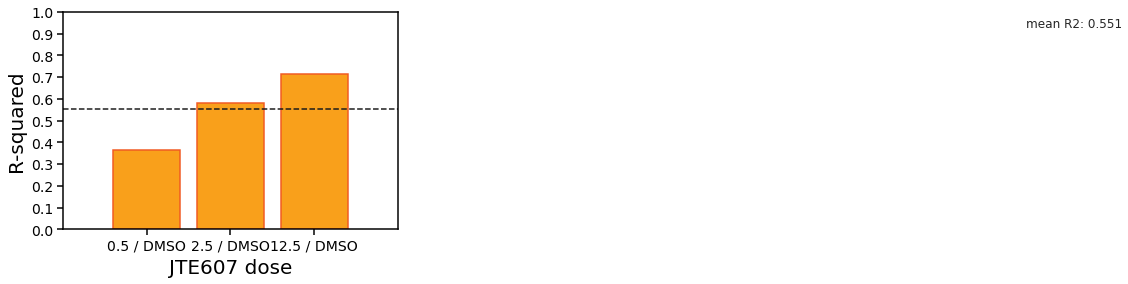

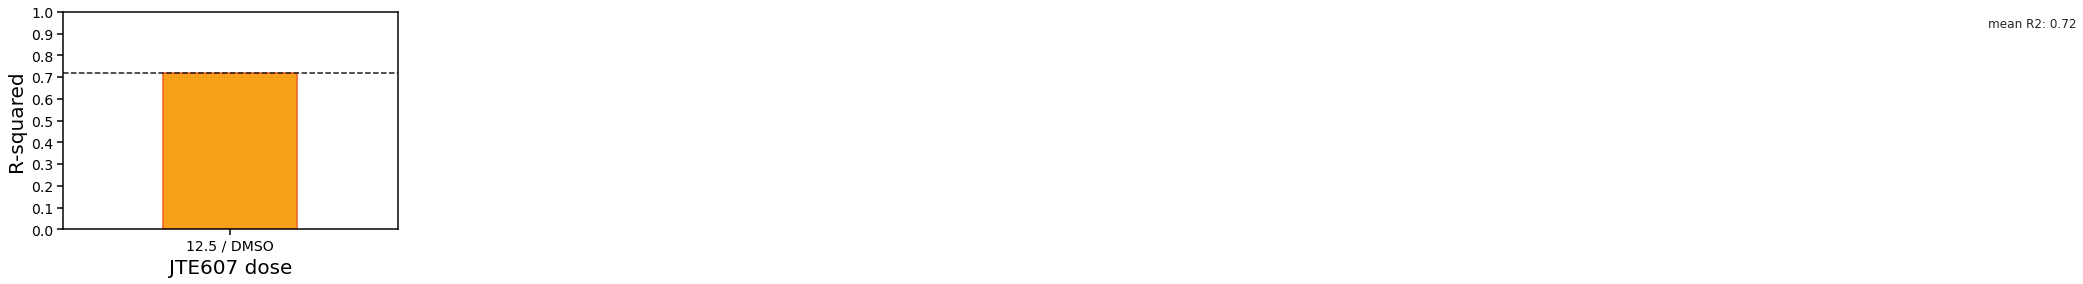

In [6]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 1

trial_num = 1

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1316
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0929
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0904
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0883
Epoch 5/6
2442/2442 [==============================] - 11s 4ms/step - loss: 0.0863
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0839
[[ 0.02780779  0.19743466  0.39478102]
 [-0.26192865 -0.13772184 -0.28320086]
 [-0.13901651 -0.3163126  -0.75807095]
 ...
 [-0.02384749  0.28698626  0.4022303 ]
 [-0.09174364 -0.01779184 -0.1773859 ]
 [ 0.01546751  0.02844323  0.00255251]]
predictions:  [ 0.02780779 -0.26192865 -0.13901651 ... -0.02384749 -0.09174364
  0.01546751]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1622
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1195
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1151
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1113
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1071
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1034
[[ 0.43912566]
 [-0.08179687]
 [-0.7557585 ]
 ...
 [ 0.27906144]
 [-0.09560344]
 [ 0.00089087]]
predictions:  [ 0.43912566 -0.08179687 -0.7557585  ...  0.27906144 -0.09560344
  0.00089087]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



scores [0.729]


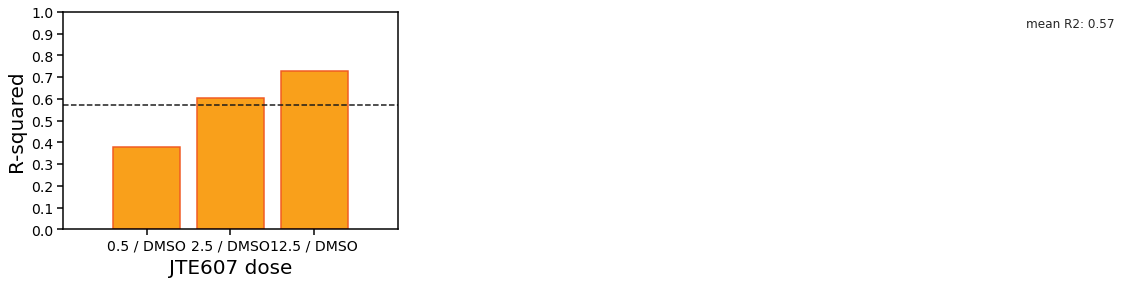

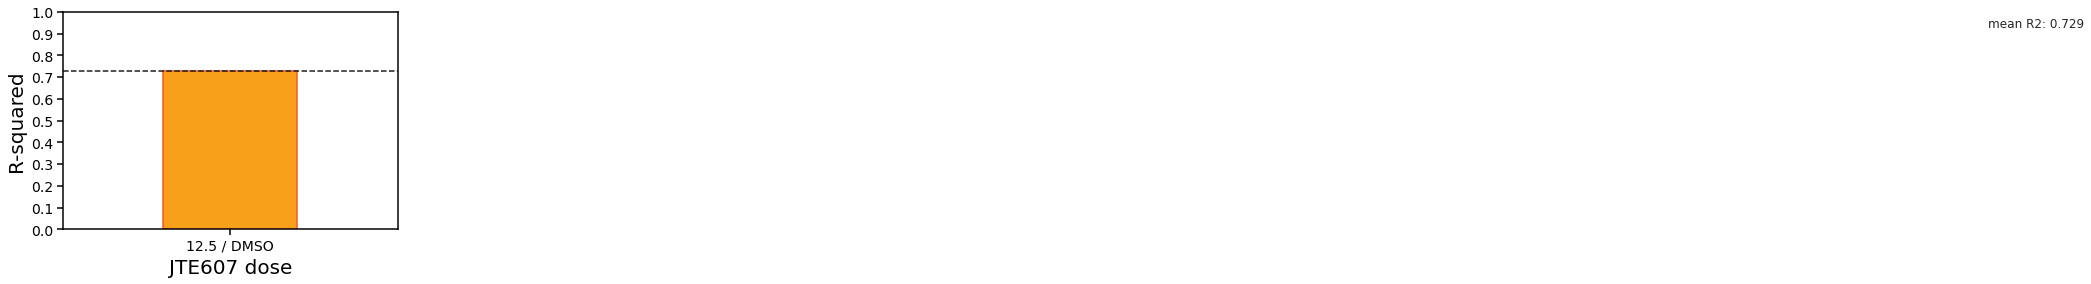

In [7]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 2

trial_num = 2

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1322
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0926
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0901
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0882
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0861
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0839
[[ 0.03208647  0.17089275  0.39583123]
 [-0.16864409 -0.06128283 -0.0812846 ]
 [-0.18170159 -0.4108967  -0.86947095]
 ...
 [-0.10939368  0.22346145  0.35571873]
 [-0.02426883  0.05484306 -0.12743893]
 [ 0.05094776  0.11437862  0.12826934]]
predictions:  [ 0.03208647 -0.16864409 -0.18170159 ... -0.10939368 -0.02426883
  0.05094776]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1731
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1200
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1152
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1111
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1069
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1039
[[ 0.43593517]
 [-0.029231  ]
 [-0.837817  ]
 ...
 [ 0.21119994]
 [-0.2718151 ]
 [ 0.06826387]]
predictions:  [ 0.43593517 -0.029231   -0.837817   ...  0.21119994 -0.2718151
  0.06826387]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.721]


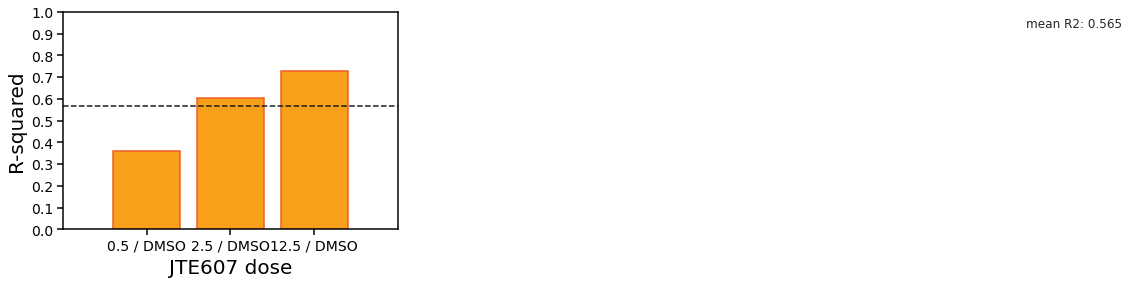

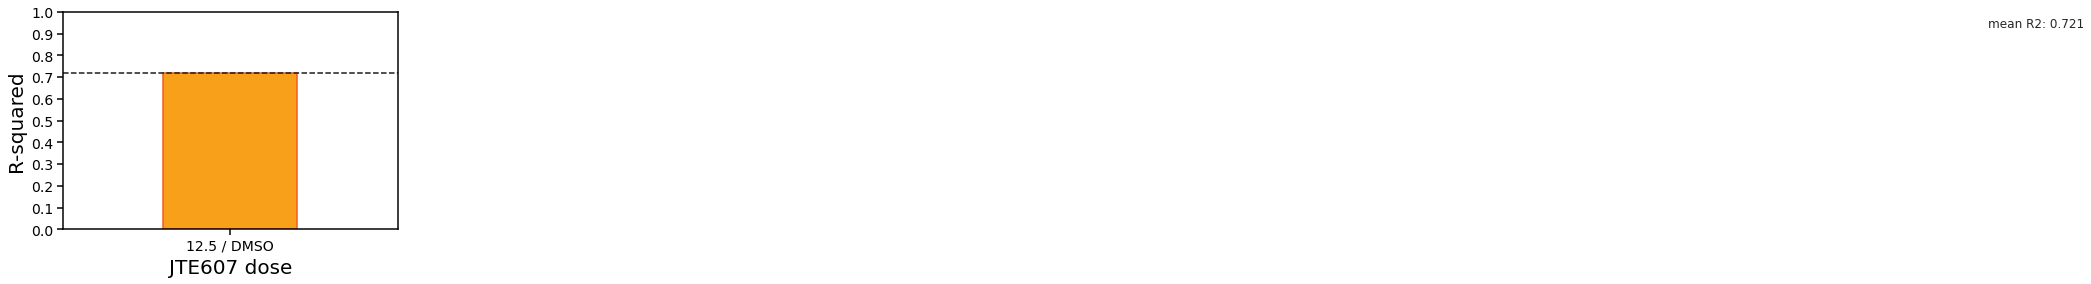

In [8]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 3

trial_num = 3

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1391
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0940
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0905
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0881
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0863
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0841
[[ 0.03448602  0.19527039  0.44201887]
 [-0.21181418 -0.09689447 -0.11317383]
 [-0.21285829 -0.47382274 -0.9237107 ]
 ...
 [-0.09437253  0.17589433  0.2703666 ]
 [-0.1151704  -0.12126334 -0.30870172]
 [ 0.03874167  0.07246763  0.1076825 ]]
predictions:  [ 0.03448602 -0.21181418 -0.21285829 ... -0.09437253 -0.1151704
  0.03874167]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0.

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1651
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1197
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1151
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1112
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1076
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1035
[[ 0.42440525]
 [-0.09696826]
 [-0.66193706]
 ...
 [ 0.24379382]
 [-0.114781  ]
 [ 0.12637824]]
predictions:  [ 0.42440525 -0.09696826 -0.66193706 ...  0.24379382 -0.114781
  0.12637824]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.725]


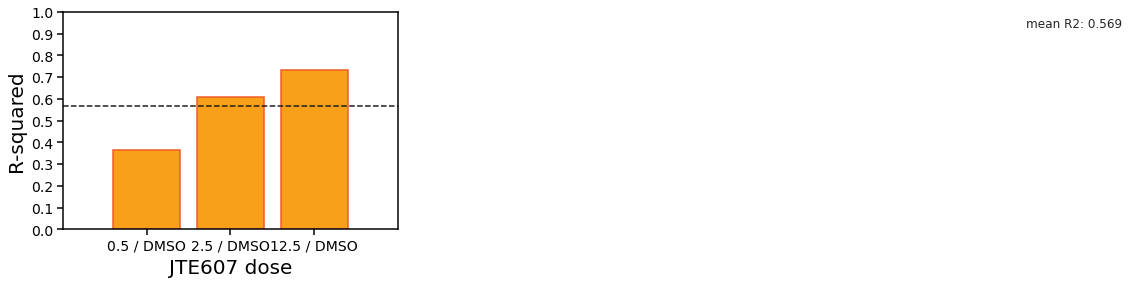

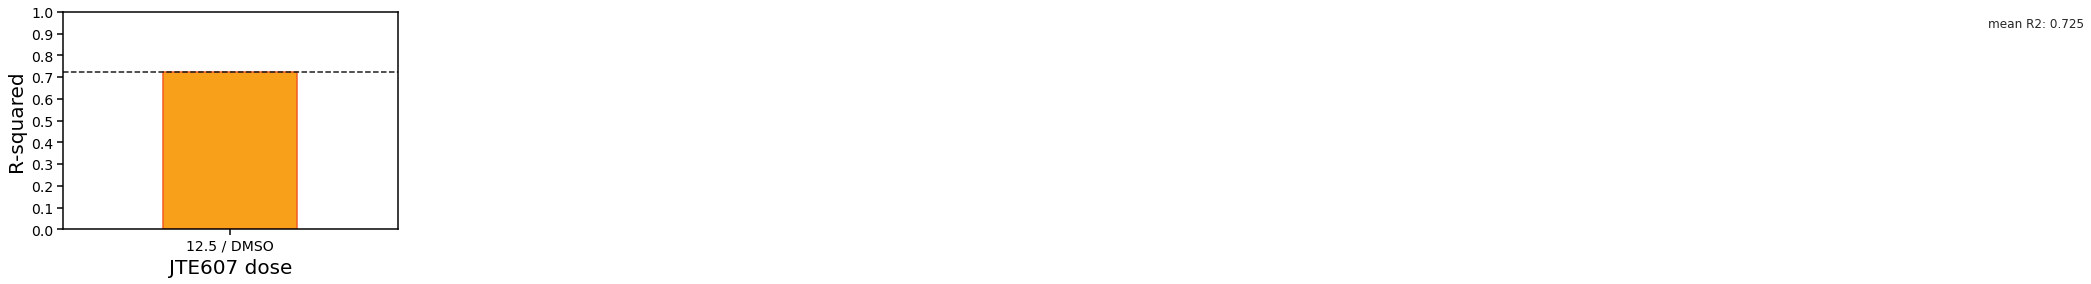

In [9]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 4

trial_num = 4

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1373
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0932
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0903
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0882
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0860
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0840
[[ 0.07542649  0.29492056  0.57236916]
 [-0.0863688  -0.02910585 -0.11533232]
 [-0.28255704 -0.5480186  -0.98396945]
 ...
 [-0.05603896  0.24066249  0.3811324 ]
 [-0.06150177 -0.03422326 -0.19983044]
 [-0.02214328 -0.00775706 -0.06800894]]
predictions:  [ 0.07542649 -0.0863688  -0.28255704 ... -0.05603896 -0.06150177
 -0.02214328]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1727
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1200
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1150
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1112
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1076
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1039
[[ 0.4991245 ]
 [-0.19134223]
 [-0.96323264]
 ...
 [ 0.34723395]
 [ 0.02488574]
 [ 0.08211765]]
predictions:  [ 0.4991245  -0.19134223 -0.96323264 ...  0.34723395  0.02488574
  0.08211765]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.708]


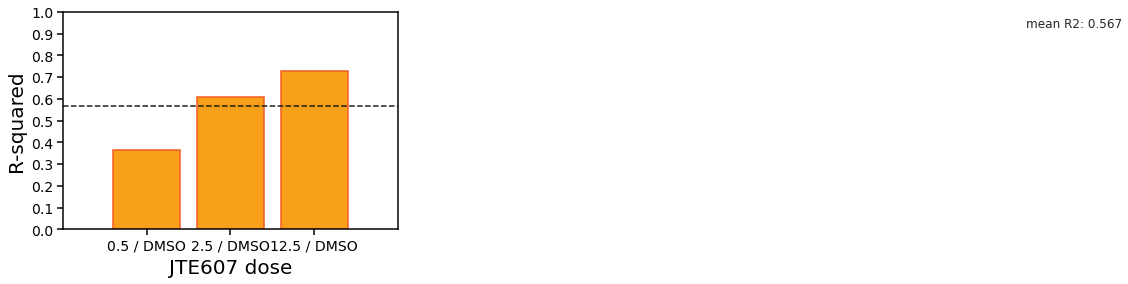

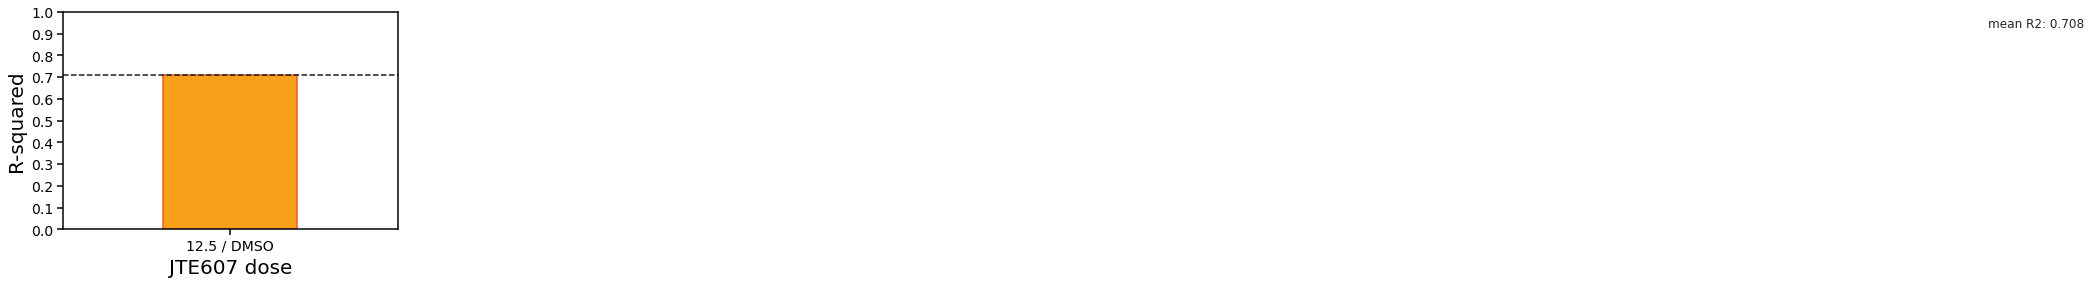

In [10]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 5

trial_num = 5

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1322
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0928
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0906
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0883
Epoch 5/6
2442/2442 [==============================] - 12s 5ms/step - loss: 0.0862
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0840
[[ 0.187523    0.27640316  0.4776428 ]
 [-0.13674806 -0.03301081 -0.01162021]
 [-0.14142624 -0.29298005 -0.7174969 ]
 ...
 [ 0.03581276  0.3270885   0.49973366]
 [-0.02367628  0.05673853 -0.0919468 ]
 [ 0.01196769  0.1012767   0.07337582]]
predictions:  [ 0.187523   -0.13674806 -0.14142624 ...  0.03581276 -0.02367628
  0.01196769]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1837
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1196
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1156
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1122
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1081
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1044
[[ 0.4698404 ]
 [-0.17138913]
 [-0.7698948 ]
 ...
 [ 0.20320804]
 [-0.16200963]
 [ 0.03877489]]
predictions:  [ 0.4698404  -0.17138913 -0.7698948  ...  0.20320804 -0.16200963
  0.03877489]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.728]


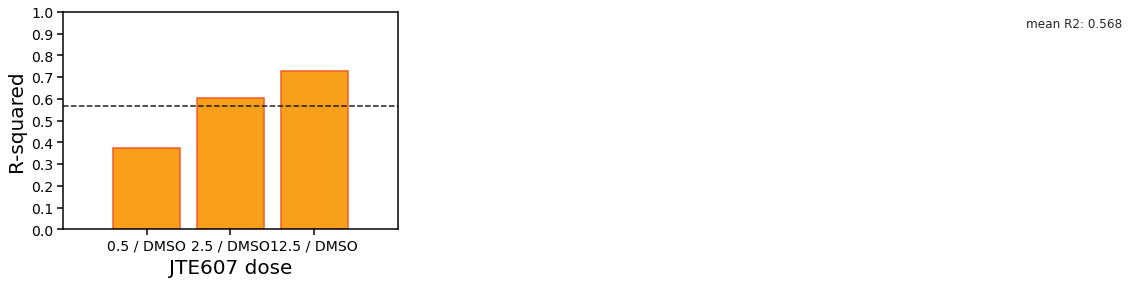

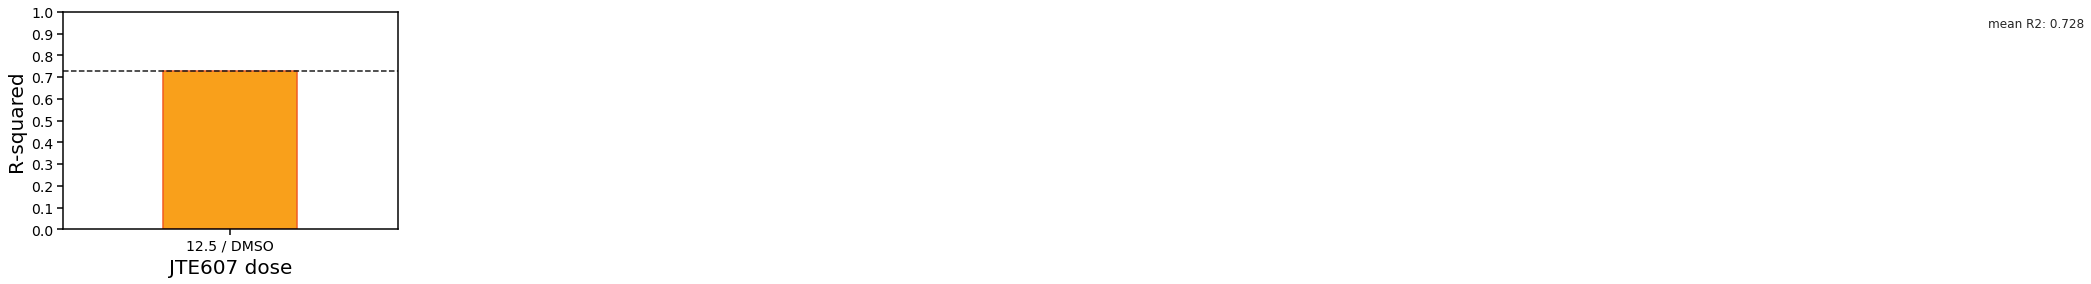

In [11]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 6

trial_num = 6

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1372
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0929
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0905
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0883
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0863
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0840
[[ 0.03427202  0.21602416  0.36575538]
 [-0.09343982 -0.08962463 -0.18039244]
 [-0.22707775 -0.40105218 -0.8128186 ]
 ...
 [-0.10463446  0.10945576  0.1739538 ]
 [-0.0655005  -0.00366109 -0.12657544]
 [ 0.00104557  0.05801235  0.04146805]]
predictions:  [ 0.03427202 -0.09343982 -0.22707775 ... -0.10463446 -0.0655005
  0.00104557]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0.

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1554
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1191
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1150
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1105
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1066
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1031
[[ 0.511771  ]
 [-0.08597399]
 [-0.7806663 ]
 ...
 [ 0.5508864 ]
 [ 0.07132484]
 [ 0.00403991]]
predictions:  [ 0.511771   -0.08597399 -0.7806663  ...  0.5508864   0.07132484
  0.00403991]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.729]


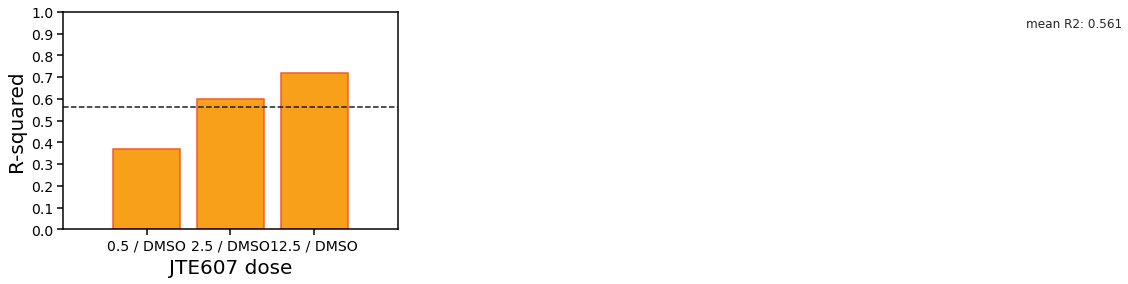

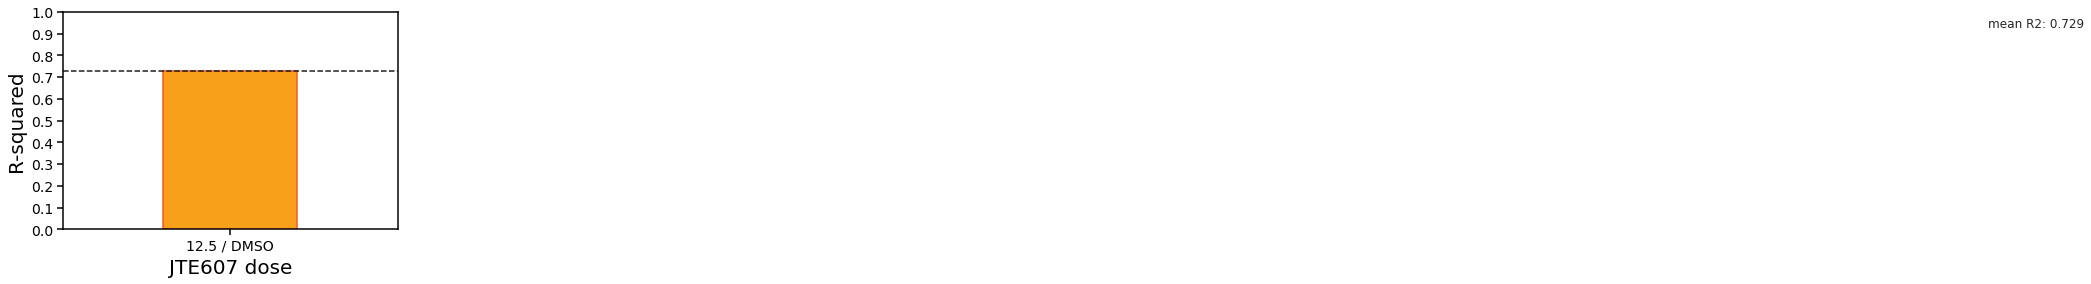

In [12]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 7

trial_num = 7

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1295
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0926
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0902
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0879
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0858
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0838
[[ 0.08925197  0.23858197  0.39572522]
 [-0.13398807 -0.09285401 -0.14310044]
 [-0.12757164 -0.3379597  -0.7510425 ]
 ...
 [-0.05673118  0.27375674  0.4184583 ]
 [ 0.0150045   0.07334033 -0.02002156]
 [ 0.02317438  0.0115098  -0.04689005]]
predictions:  [ 0.08925197 -0.13398807 -0.12757164 ... -0.05673118  0.0150045
  0.02317438]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0.

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1727
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1197
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1159
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1120
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1077
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1042
[[ 0.36823365]
 [-0.12953457]
 [-0.7925353 ]
 ...
 [ 0.3295548 ]
 [-0.01956929]
 [ 0.15499854]]
predictions:  [ 0.36823365 -0.12953457 -0.7925353  ...  0.3295548  -0.01956929
  0.15499854]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.724]


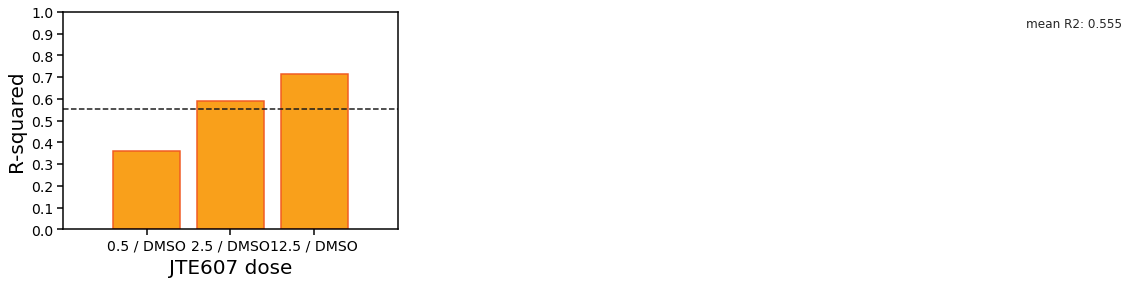

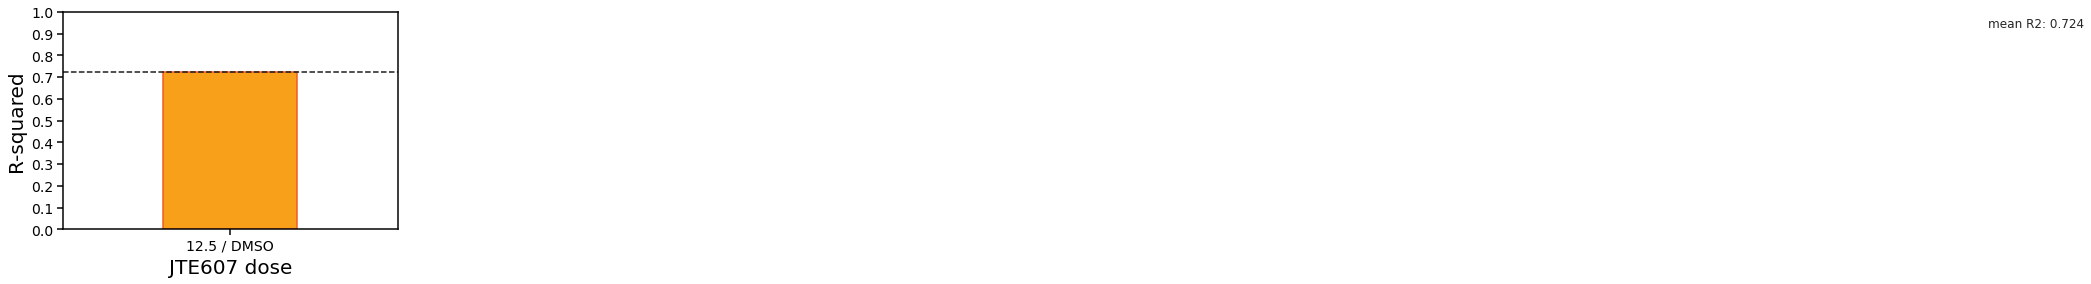

In [13]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 8

trial_num = 8

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1387
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0930
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0904
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0883
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0864
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0843
[[-9.2720427e-04  1.6047931e-01  3.4843695e-01]
 [-1.7941831e-01 -9.5830135e-02 -1.8736401e-01]
 [-2.1961986e-01 -4.3738174e-01 -9.2756438e-01]
 ...
 [-7.9899244e-02  1.9902024e-01  2.9134429e-01]
 [-1.5300661e-03  1.0110110e-01 -4.8489451e-02]
 [ 1.2271203e-01  1.5153335e-01  1.5311885e-01]]
predictions:  [-0.0009272  -0.17941831 -0.21961986 ... -0.07989924 -0.00153007
  0.12271203]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055  

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1682
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1193
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1156
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1116
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1077
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1043
[[ 0.5488695 ]
 [-0.19307491]
 [-0.6273571 ]
 ...
 [ 0.37124246]
 [ 0.15264328]
 [ 0.14755051]]
predictions:  [ 0.5488695  -0.19307491 -0.6273571  ...  0.37124246  0.15264328
  0.14755051]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



scores [0.724]


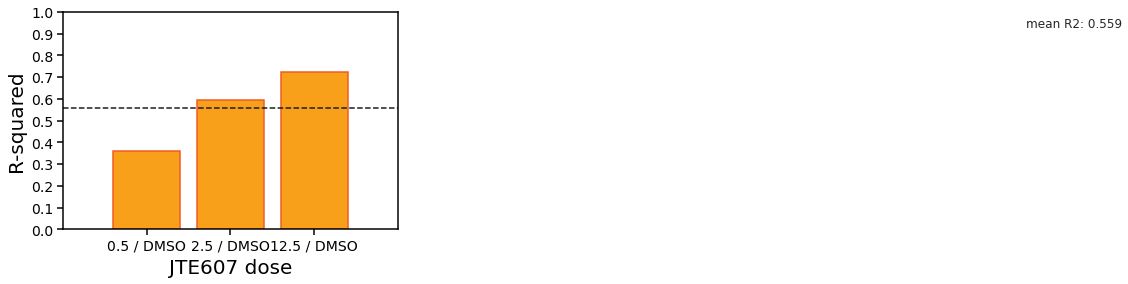

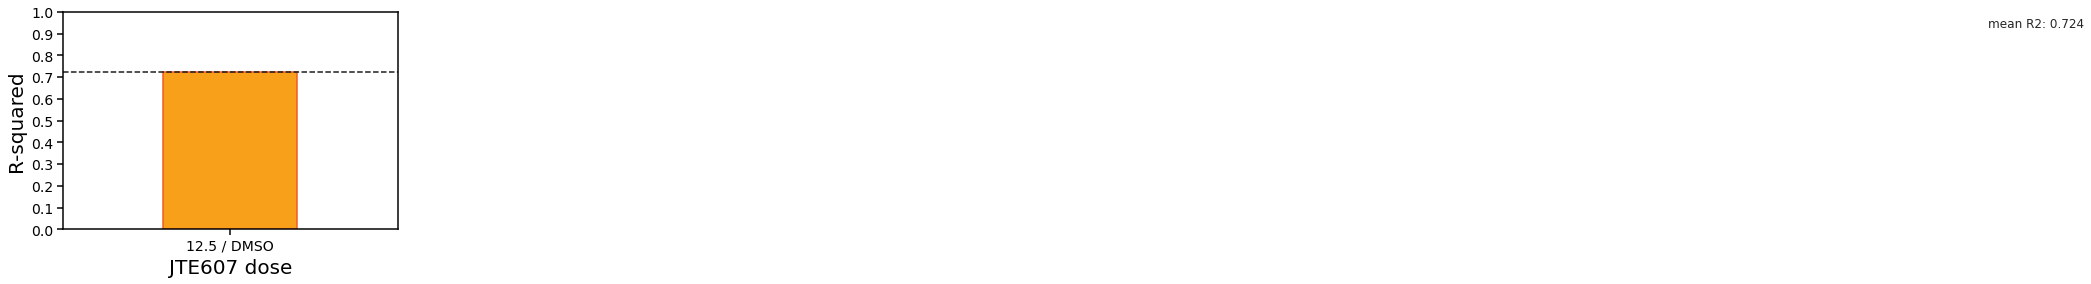

In [14]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 9

trial_num = 9

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1346
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0932
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0903
Epoch 4/6
2442/2442 [==============================] - 12s 5ms/step - loss: 0.0881
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0857
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.0838
[[ 0.11684456  0.29177985  0.50255334]
 [-0.19997343 -0.05314862 -0.14488995]
 [-0.1677588  -0.2661384  -0.6958951 ]
 ...
 [-0.03351231  0.22927962  0.2840743 ]
 [-0.06577593  0.02891752 -0.13820913]
 [ 0.03907448  0.06628321  0.02911414]]
predictions:  [ 0.11684456 -0.19997343 -0.1677588  ... -0.03351231 -0.06577593
  0.03907448]
test:  0      -0.063896
1      -0.169079
2      -0.263721
3      -0.167095
4       0.027381
          ...   
2055   -0.149442
2056    0.037770
2057    0.246171
2058    0

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Epoch 1/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1954
Epoch 2/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1204
Epoch 3/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1157
Epoch 4/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1123
Epoch 5/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1087
Epoch 6/6
2442/2442 [==============================] - 11s 5ms/step - loss: 0.1049
[[ 0.53591156]
 [-0.08304869]
 [-0.8858279 ]
 ...
 [ 0.43145165]
 [-0.21748303]
 [ 0.21763185]]
predictions:  [ 0.53591156 -0.08304869 -0.8858279  ...  0.43145165 -0.21748303
  0.21763185]
test:  0       0.408453
1       0.017941
2      -1.410902
3      -0.215323
4      -0.344722
          ...   
2055   -0.549716
2056    0.070861
2057    0.450916
2058    0.182652
2059    0.070861
Name: 12p5uM_percent, Length: 2060, dtype: float64


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/ipykernel/__main__.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


scores [0.725]


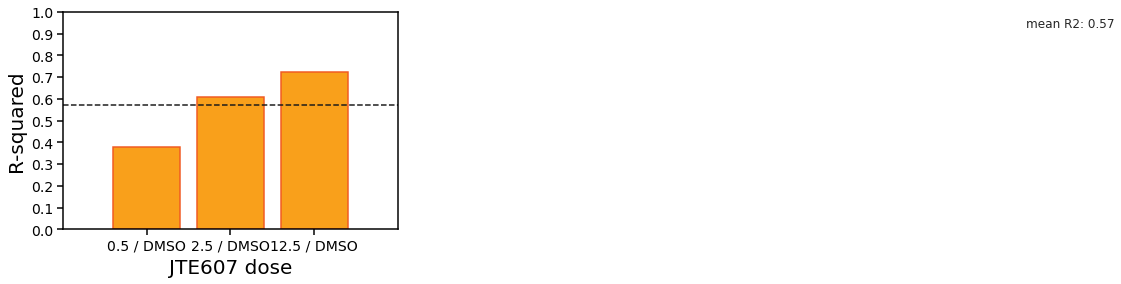

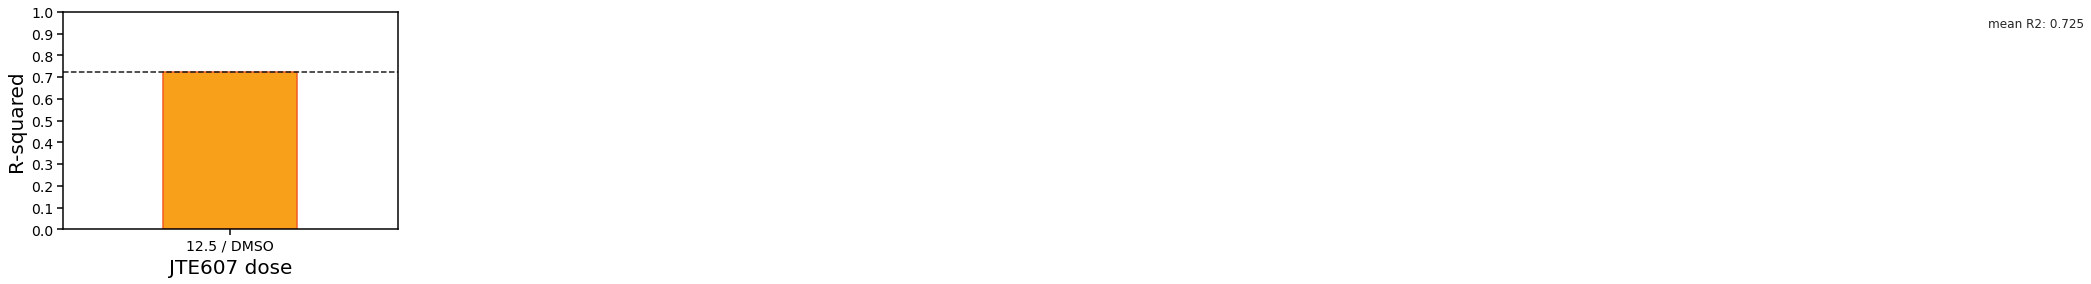

In [15]:
# going forward with merged_PAS_ratio, taking top 4120/2, 6 epochs, Trial 10

trial_num = 10

"""
Train model. 
TODO: look up "Using the hyperparameter-optimised values."
"""
model = weighted_poly_profile_model_mask(seq_e_train, res_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", res_test[res_test.columns[0]])
for i in range(3):
    pred = predictions[:,i]
    obs = res_test[res_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, trial_num))


"""
Train model using only 0 and 12.5
TODO: look up "Using the hyperparameter-optimised values."
"""
print(res_train.columns)
two_columns_train = res_train.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_train = two_columns_train.div(two_columns_train.sum(axis=1), axis=0)

model = weighted_poly_profile_model_mask(seq_e_train, two_columns_train, res_weight, nb_epoch=6,border_mode='same',
                   inp_len=input_len, nodes=80, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.1)

two_columns_test = res_test.drop(['0p5uM_percent', '2p5uM_percent'], 1)
#two_columns_test = two_columns_test.div(two_columns_test.sum(axis=1), axis=0)

predictions = model.predict(seq_e_test)
print(predictions)
scores = []
print("predictions: ", predictions[:,0])
print("test: ", two_columns_test[two_columns_test.columns[0]])
for i in range(1):
    pred = predictions[:,i]
    obs = two_columns_test[two_columns_test.columns[i]]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,1));
ax.set_xlim((-1,1))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20);

print("scores", scores)

model.save("%s/JTE607_CNN_25nt_6epoch_2col_model_%s.hdf5" % (output_models_dir, trial_num))


In [16]:
#run on test sets 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, linregress

def relevant_metrics(y_pred, y_true):
    #returns the metrics for the dataframe to save for model performance 
    #sklearn r2 is not the linear coefficent 
    #using the scpy linregress function to get that r2
    res = linregress(y_pred, y_true)
    return mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred), res.rvalue**2, spearmanr(y_true, y_pred)[0]

In [17]:
# Plot predictions of best performing model of all data

all_doses_trial_num = 4

model = load_model("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, all_doses_trial_num))
output_path_prefix = output_models_dir + "/JTE607_CNN_softmax_25nt_6epoch_4col_model_%s" % (all_doses_trial_num)

data_train_x = pickle.load(open(output_data_dir + "seq_e_train.p", "rb"))
data_train_y = pickle.load(open(output_data_dir + "res_train.p", "rb"))
data_test_x = pickle.load(open(output_data_dir + "seq_e_test.p", "rb"))
data_test_y = pickle.load(open(output_data_dir + "res_test.p", "rb"))


[[-0.39632505 -0.7315455  -1.0911536 ]
 [ 0.09877834  0.33890438  0.45919478]
 [-0.15415594 -0.4515069  -0.81358314]
 ...
 [ 0.19295941  0.4627296   0.80572885]
 [-0.13284785 -0.19955947 -0.42832533]
 [-0.00432266 -0.05752337 -0.1984891 ]]
        0p5uM_percent  2p5uM_percent  12p5uM_percent
123447      -0.000476      -1.052030       -1.096567
103836       0.139465       0.685653        0.667502
65710        0.079567      -0.260491       -1.922765
10263        0.032610      -0.010846       -0.273754
139374       0.443235       0.090907        0.421063
...               ...            ...             ...
73598        0.208184      -0.036278       -0.116407
156006      -0.431259       0.126625       -0.187576
119475       0.329221       0.802206        1.029109
11508       -0.354886       0.043933       -0.189846
5283         0.064299       0.058714       -0.177526

[156238 rows x 3 columns]


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


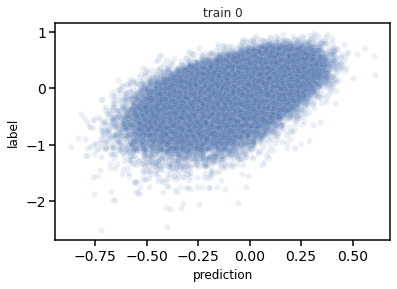

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


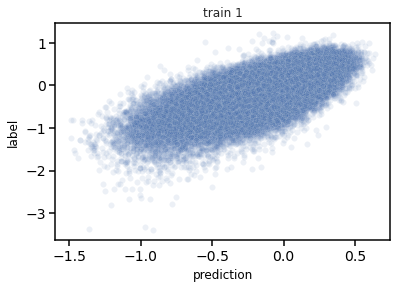

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


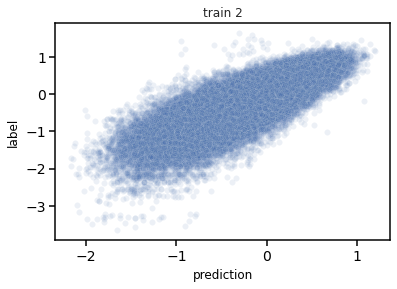

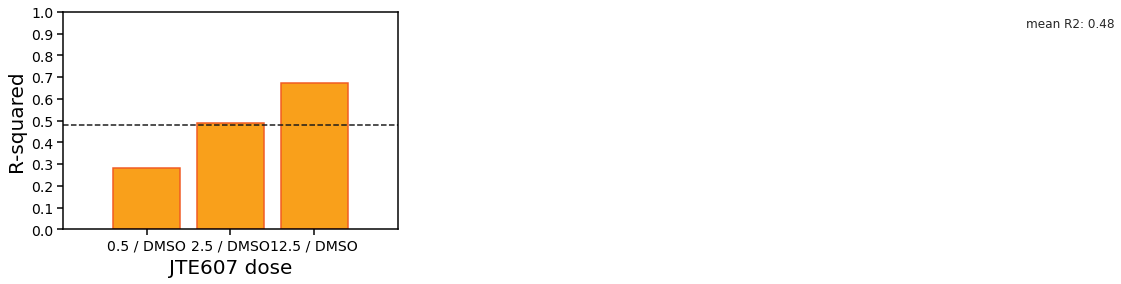

scores [0.282, 0.488, 0.671]


In [18]:
#evaluate on data 
import seaborn as sns
import scipy.stats as stats

#predict train, val, test sets 
x_preds = model.predict(data_train_x)
print(x_preds)
print(data_train_y)


scores = []
for i in range(3):
    pred = x_preds[:,i]
    obs = data_train_y[data_train_y.columns[i]]
    slope, intercept, r_value, p_value, std_err = linregress(obs,pred)
    scores.append(round(r_value**2, 3))
    
    sns.scatterplot(pred, obs, alpha = 0.1)
    plt.xlabel('prediction')
    plt.ylabel('label')
    plt.title('train %s' % (i))
    plt.savefig(output_path_prefix+"_scatter_train_%s.pdf" % (i))
    plt.show()
    relevant_metrics(pred, obs)

mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20)
plt.savefig(output_path_prefix+"_train_scatter.pdf")
plt.show()

print("scores", scores)


[[ 0.03448602  0.19527039  0.44201887]
 [-0.21181418 -0.09689447 -0.11317383]
 [-0.21285829 -0.47382274 -0.9237107 ]
 ...
 [-0.09437253  0.17589433  0.2703666 ]
 [-0.1151704  -0.12126334 -0.30870172]
 [ 0.03874167  0.07246763  0.1076825 ]]
      0p5uM_percent  2p5uM_percent  12p5uM_percent
0         -0.063896       0.214028        0.408453
1         -0.169079       0.045483        0.017941
2         -0.263721      -0.588781       -1.410902
3         -0.167095      -0.095036       -0.215323
4          0.027381      -0.157408       -0.344722
...             ...            ...             ...
2055      -0.149442      -0.026876       -0.549716
2056       0.037770       0.149747        0.070861
2057       0.246171       0.316069        0.450916
2058       0.246171       0.039082        0.182652
2059       0.216018       0.100957        0.070861

[2060 rows x 3 columns]


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


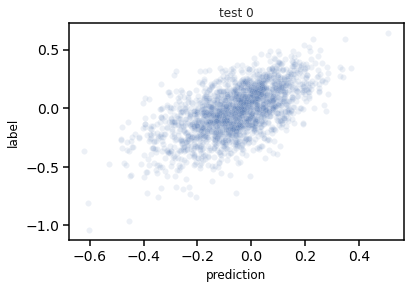

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


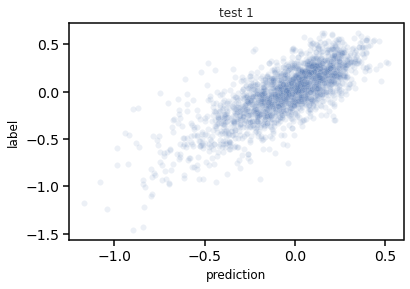

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


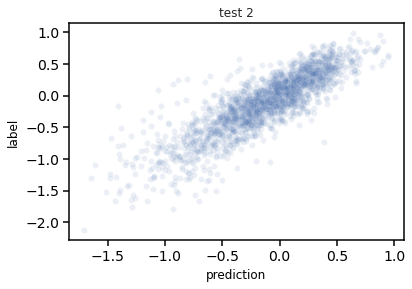

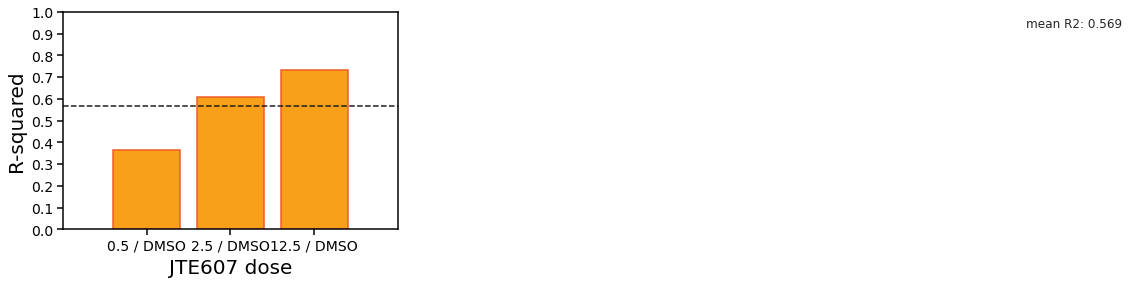

scores [0.366, 0.61, 0.731]


In [19]:
#evaluate on data 
#predict train, val, test sets 
x_preds = model.predict(data_test_x)
print(x_preds)
print(data_test_y)

scores = []
for i in range(3):
    pred = x_preds[:,i]
    obs = data_test_y[data_test_y.columns[i]]
    slope, intercept, r_value, p_value, std_err = linregress(obs,pred)
    scores.append(round(r_value**2, 3))
    
    sns.scatterplot(pred, obs, alpha = 0.1)
    plt.xlabel('prediction')
    plt.ylabel('label')
    plt.title('test %s' % (i))
    plt.savefig(output_path_prefix+"_scatter_test_%s.pdf" % (i))
    plt.show()
    relevant_metrics(pred, obs)

mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5 / DMSO", "2.5 / DMSO", "12.5 / DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20)
plt.savefig(output_path_prefix+"_test_scatter.pdf")
plt.show()

print("scores", scores)
